<a href="https://colab.research.google.com/github/Rhitabrat/deep-learning-CS510/blob/main/hw1/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

HW 1

#Import the libraries and load the data

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset
from torchvision import transforms
from typing import List, Any
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [3]:
train_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_train.csv"
test_file_path = "/content/drive/Othercomputers/My MacBook Pro/PSU/Winter-2022/Deep Learning/Assignments/Assignment 1/FMNIST Dataset/fashion-mnist_test.csv"

In [5]:
# let's see how our data looks like
data_train = pd.read_csv(train_file_path)
data_test = pd.read_csv(test_file_path)
data_train.head(3)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0


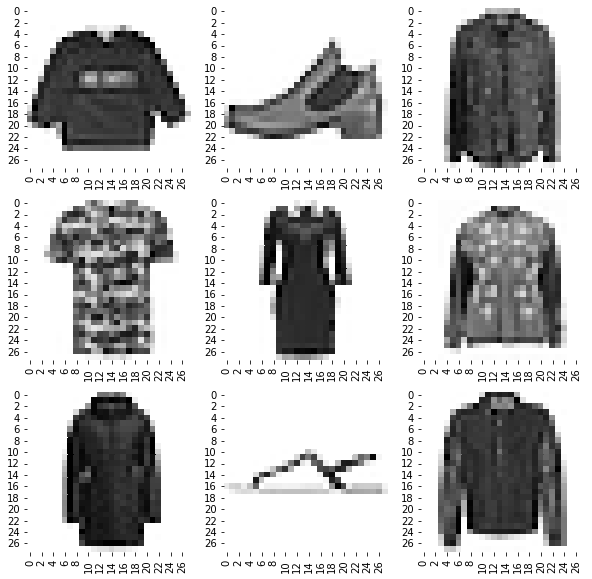

In [8]:
# visualizing some of the images

fig = plt.figure(figsize=(10,10))
for i in range(1,10):
    fig.add_subplot(3,3,i)
    sns.heatmap(np.array(data_train.iloc[i-1,1:]).reshape(28,28), cbar=False, cmap='Greys');

In [9]:
# getting the data ready for transforming

class FashionMNIST(Dataset):
    def __init__(self, data, transform=None):
        self.transform = transform
        self.labels = data.label.values
        self.images = data.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [10]:
# normalize the data and loading them for our model
data = pd.read_csv(train_file_path)
mean = np.array(data.iloc[:,1:]).flatten().mean()
std  = np.array(data.iloc[:,1:]).flatten().std()
transf = transforms.Compose([transforms.ToTensor(), transforms.Normalize((mean/225,), (std/225,))])

data_test  = FashionMNIST(data_test,transform=transf)
data_train = FashionMNIST(data_train,transform=transf)

# Neural Network

In [11]:
# some global variables
INPUT_SIZE = 784
OUTPUT_SIZE = 10

In [12]:
class NNetwork(torch.nn.Module):

    def __init__(self, hidden_size: List, activation):
        super().__init__()

        self.hidden_size = hidden_size

        self.activation = activation

        modules = []
        modules.append(nn.Linear(in_features=INPUT_SIZE, out_features=hidden_size[0]))
        modules.append(self.activation)

        for i in range(len(hidden_size) - 1):
            modules.append(nn.Linear(in_features=hidden_size[i], out_features=hidden_size[i + 1]))
            modules.append(self.activation)

        modules.append(nn.Linear(in_features=hidden_size[len(hidden_size) - 1], out_features=OUTPUT_SIZE))

        self.module_list = nn.ModuleList(modules=modules)

    def forward(self, x):

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        for f in self.module_list:
            x = x.to(device)
            x = f(x)

        x = x.to(device)
        return x

In [13]:
model = None
params = []
train_accuracy = []
test_accuracy = []
loss_train = []
loss_test = []
batch_size = 30
criterion = nn.CrossEntropyLoss()
data_train = data_train
data_test = data_test



In [14]:
class FashionModel():
    """
    FashionModel is the class object that encapsulates our model
    """

    def __init__(self, data_train, data_test, batch_size: int ) -> None:
        self.model = None
        self.params = []
        self.train_accuracy = []
        self.test_accuracy = []
        self.loss_train = []
        self.loss_test = []
        self.batch_size = batch_size
        self.criterion = nn.CrossEntropyLoss()
        self.data_train = data_train
        self.data_test = data_test


    def test(self) -> None:
        """
        Evaluate a model
        """

        batch_length = len(self.test_loader)
        with torch.no_grad():
            correct = 0
            total = 0
            for batch_id, (image, label) in enumerate(self.test_loader, start=1):
                image = image.view(image.shape[0], -1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)
                outputs = self.model(image)

                if (batch_id / batch_length == 1):
                    loss = self.criterion(outputs, label)
                    self.loss_test.append(loss.item())
                    print(f"Testing Loss: {loss.item():.4f}   ", end=' ')

                predicted = torch.argmax(input=outputs, dim=1)
                total += label.size(0)
                correct += (predicted == label).sum().item()

        accuracy = 100 * correct / total
        self.test_accuracy.append(accuracy)
        print(f"Testing Accuracy: {accuracy}%")

    def train(self, hidden_size: List, activation: Any, learn_rate: float, momentum: float, epochs: int) -> None:
        """
        Train a fully connected neural network classifier on a dataset of fashion images
        """
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model = NNetwork(hidden_size=hidden_size, activation=activation)
        self.model.to(device)

        # Print Training Parameters
        print(f"Hidden Layers: {hidden_size}")
        print(f"Learning Rate: {learn_rate}")
        print(f"Activation:    {activation.__str__()}")
        print(f"Batch Size:    {self.batch_size}")
        print(f"Epochs:        {epochs}")
        print("------------------------------------------------------------------------------------------")

        self.train_loader = torch.utils.data.DataLoader(dataset=self.data_train, batch_size=self.batch_size, shuffle=True)
        self.test_loader = torch.utils.data.DataLoader(dataset=self.data_test, batch_size=self.batch_size, shuffle=True)

        optimizer = torch.optim.SGD(params=self.model.parameters(), lr=learn_rate, momentum=momentum)

        for epoch in range(1, epochs + 1):
            for batch_id, (image, label) in enumerate(self.train_loader):

                image = image.view(image.shape[0],-1)
                device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
                image = image.to(device)
                label = label.to(device)

                # Forward pass
                output = self.model(image)

                loss = self.criterion(output, label)
                loss = loss.to()
                # Initializing a gradient as 0 so there is no mixing of gradient among the batches
                optimizer.zero_grad()

                # Propagating the error backward
                loss.backward()

                # Prevent Gradient Explosion
                nn.utils.clip_grad_norm_(parameters=self.model.parameters(), max_norm=2.0, norm_type=2)
                # nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)

                # Optimizing the parameters
                optimizer.step()

            print(f"Epoch {epoch}/{epochs}  Training Loss: {loss.item():.4f}   ", end=' ')
            # print(f"Epoch {epoch}/{epochs}  Train Loss: {loss.item():.4f}   Train Accuracy: {accuracy:.2f}%   ", end=' ')
            self.loss_train.append(loss.item())
            self.test()

        for i in self.model.parameters():
            self.params.append(i)

#Experiment 1

In [18]:
hidden_size = [1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_1 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_1.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.9205    Testing Loss: 0.8331    Testing Accuracy: 74.27%
Epoch 2/2  Training Loss: 0.4355    Testing Loss: 0.4873    Testing Accuracy: 78.05%


#Experiment 2

In [16]:
hidden_size = [1024, 1024]
batch_size = 30
learn_rate = 0.001
activation = nn.ReLU()
momentum = 0
epochs = 2

model_2 = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
model_2.train(hidden_size=hidden_size, activation=activation, learn_rate=learn_rate, momentum=momentum, epochs=epochs)

Hidden Layers: [1024, 1024]
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    30
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.0295    Testing Loss: 0.7072    Testing Accuracy: 72.53%
Epoch 2/2  Training Loss: 0.6597    Testing Loss: 0.7993    Testing Accuracy: 75.76%


#Visualization

In [19]:
# %matplotlib inline
# %matplotlib notebook
# %matplotlib widget

# plt.rcParams['figure.figsize'] = [25, 10]
plt.rcParams['figure.figsize'] = [25, 5]


def display_model_visuals(model, title):

    # Plot Accuracy 
    plt.subplot(1,3,1)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.test_accuracy, label='Test Accuracy')
    plt.title(f"{title}: Accuracy\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.xticks(np.arange(len(model.test_accuracy)), np.arange(1, len(model.test_accuracy) + 1))
    plt.legend();

    # Plot Cross-Entropy
    plt.subplot(1,3,2)
    param_title = f"Hidden: {hidden_size}, batch: {model.batch_size}, η: {learn_rate}, φ: {activation.__str__()}"
    plt.plot(np.arange(epochs), model.loss_train, label='Train Loss')
    plt.plot(np.arange(epochs), model.loss_test, label='Test Loss')
    plt.title(f"{title}: Cross Entropy Loss\n{param_title}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xticks(np.arange(len(model.loss_test)), np.arange(1, len(model_a.loss_test) + 1))
    plt.legend();

    # Create Confusion Matrix
    nb_classes = 10
    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():
        for i, (image, classes) in enumerate(model.test_loader):
            image = image.view(image.shape[0], -1)
            outputs = model.model(image)
            _, preds = torch.max(outputs, dim=1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    cols = ["T-shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag",
            "Ankle Boot"]
    plt.subplot(1,3,3)
    plt.title(f"{title}: Confusion Matrix\n{param_title}")
    sns.heatmap(pd.DataFrame(np.array(confusion_matrix), columns=cols, index=cols), cmap='Greys', annot=True, fmt='g');
    
    plt.show()

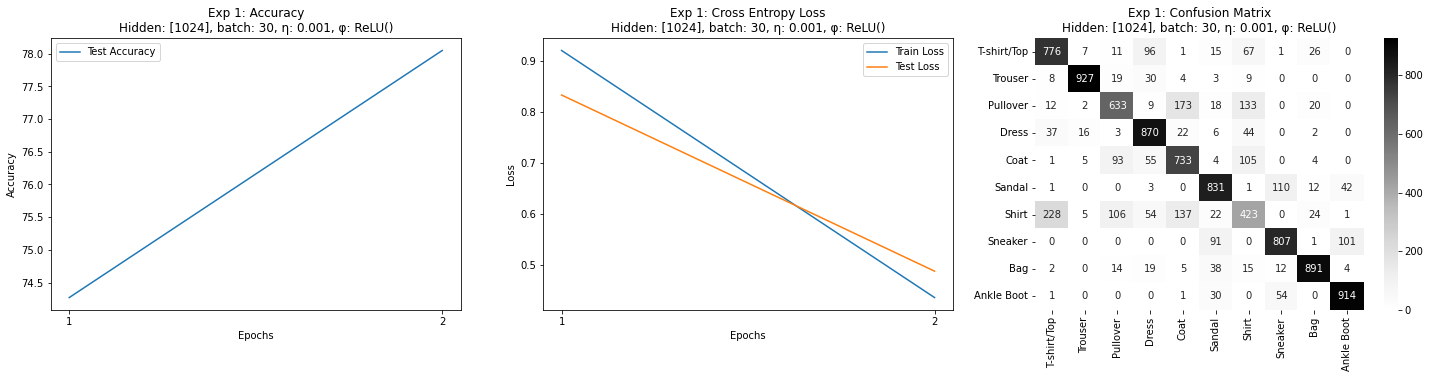

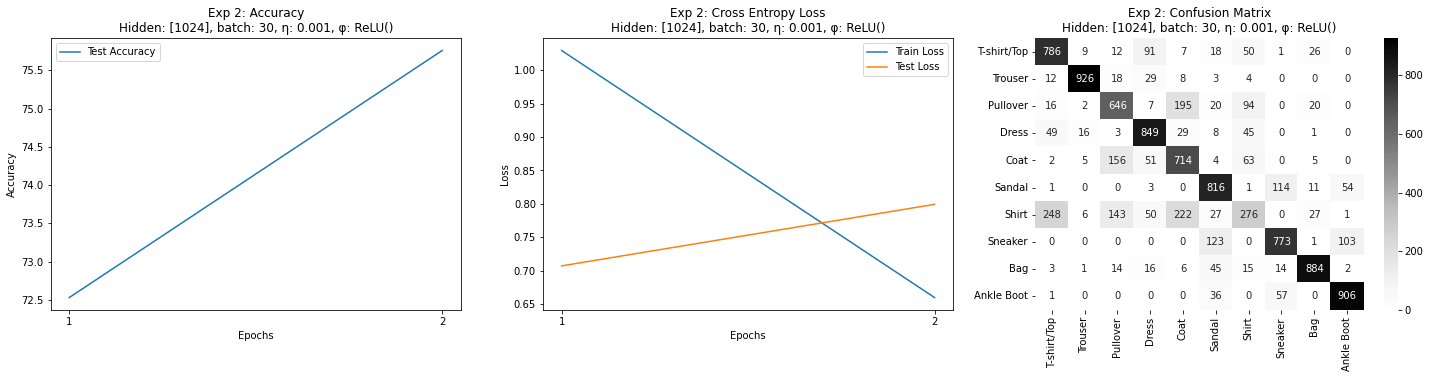

In [20]:
display_model_visuals(model_1, "Exp 1");
display_model_visuals(model_2, "Exp 2")

3*4*2=24 Model Training - Started At: 01/16/2022 22:21:46
------------------------------------------------------------------------------------------
CASE: 01 Training Started: 01/16/2022 22:21:46
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.5243    Testing Loss: 2.2056    Testing Accuracy: 26.91%
Epoch 2/2  Training Loss: 2.2895    Testing Loss: 0.0000    Testing Accuracy: 32.1%
Completed Case 1/24: 0:03:26.734398 Elapsed



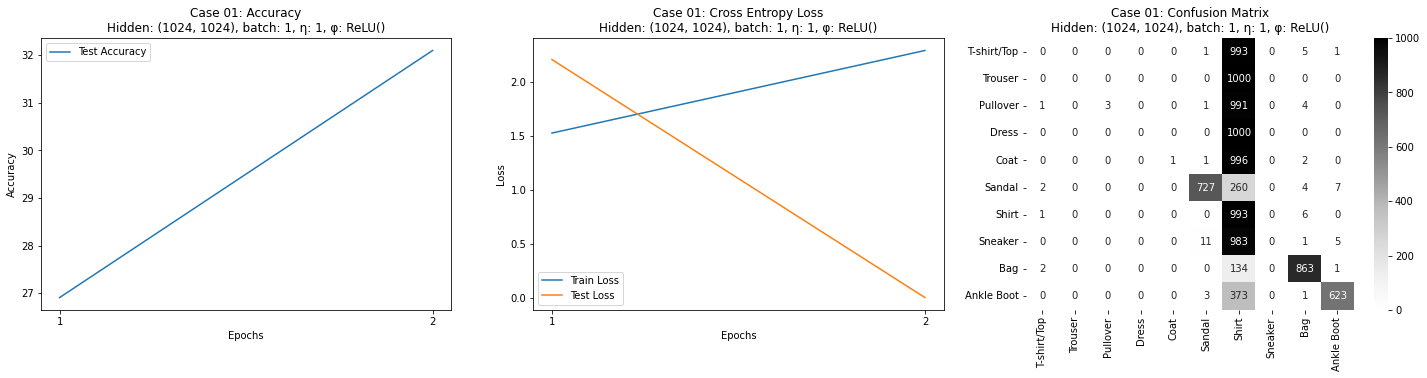

------------------------------------------------------------------------------------------
CASE: 02 Training Started: 01/16/2022 22:25:19
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0000    Testing Loss: 0.0007    Testing Accuracy: 85.36%
Epoch 2/2  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 87.44%
Completed Case 2/24: 0:03:27.611872 Elapsed



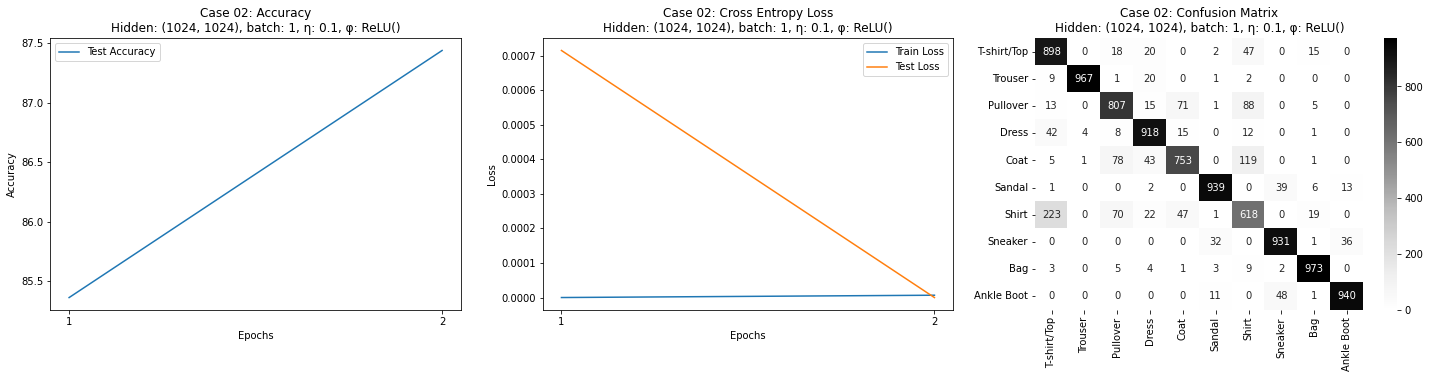

------------------------------------------------------------------------------------------
CASE: 03 Training Started: 01/16/2022 22:28:54
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 85.54%
Epoch 2/2  Training Loss: 0.0000    Testing Loss: 0.0090    Testing Accuracy: 86.71%
Completed Case 3/24: 0:03:25.227515 Elapsed



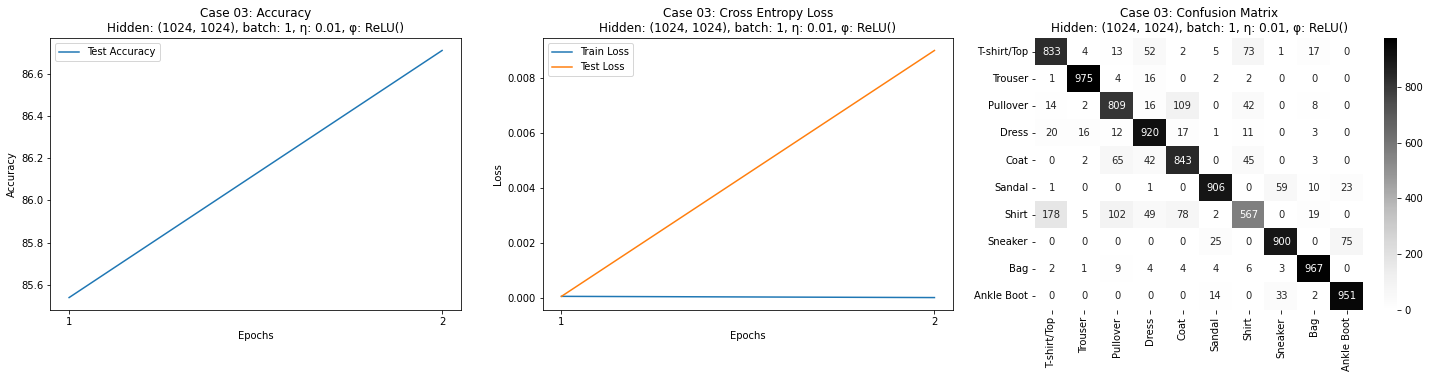

------------------------------------------------------------------------------------------
CASE: 04 Training Started: 01/16/2022 22:32:25
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.7993    Testing Loss: 4.5668    Testing Accuracy: 77.86%
Epoch 2/2  Training Loss: 0.0000    Testing Loss: 5.6942    Testing Accuracy: 81.45%
Completed Case 4/24: 0:03:23.749964 Elapsed



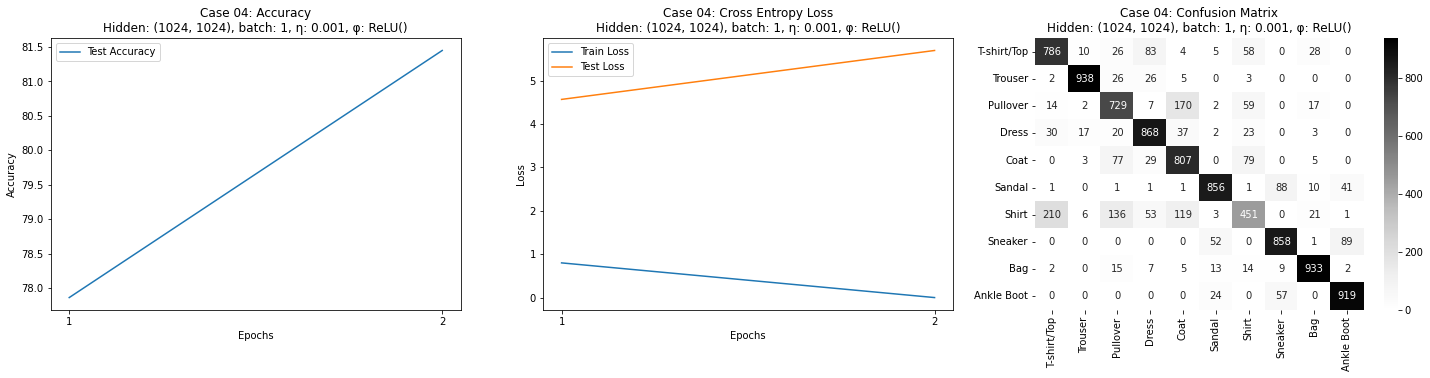

------------------------------------------------------------------------------------------
CASE: 05 Training Started: 01/16/2022 22:35:56
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 77.05%
Epoch 2/2  Training Loss: 0.0000    Testing Loss: 0.6688    Testing Accuracy: 72.75%
Completed Case 5/24: 0:03:23.537147 Elapsed



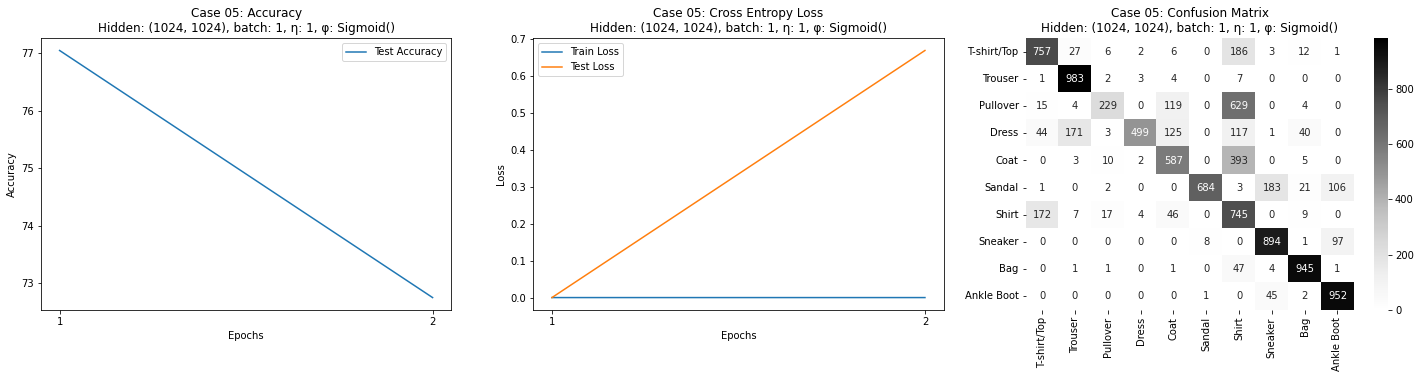

------------------------------------------------------------------------------------------
CASE: 06 Training Started: 01/16/2022 22:39:26
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.8010    Testing Loss: 3.9587    Testing Accuracy: 84.99%
Epoch 2/2  Training Loss: 0.0000    Testing Loss: 0.0000    Testing Accuracy: 86.84%
Completed Case 6/24: 0:03:24.051296 Elapsed



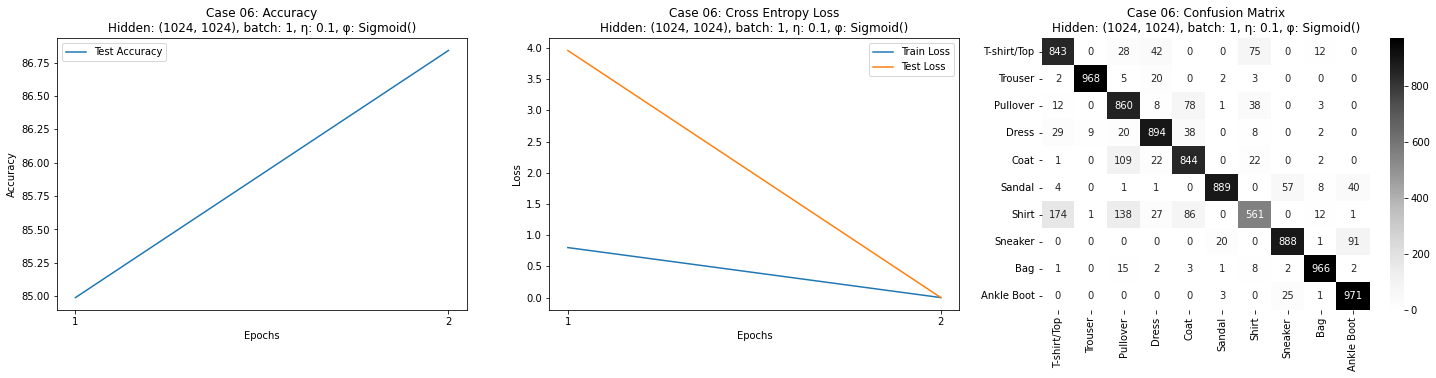

------------------------------------------------------------------------------------------
CASE: 07 Training Started: 01/16/2022 22:42:56
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.0208    Testing Loss: 0.1219    Testing Accuracy: 76.94%
Epoch 2/2  Training Loss: 1.1527    Testing Loss: 0.0000    Testing Accuracy: 80.29%
Completed Case 7/24: 0:03:23.648753 Elapsed



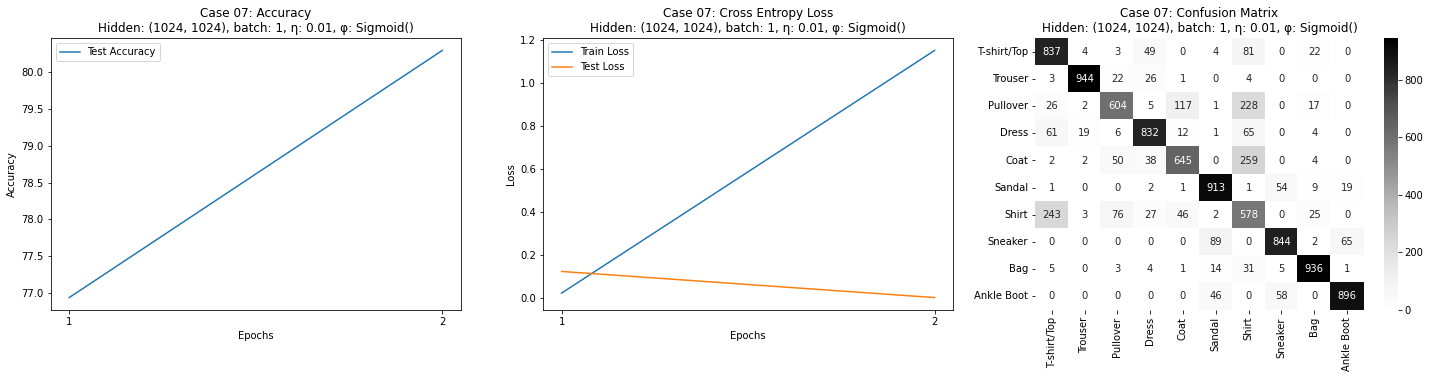

------------------------------------------------------------------------------------------
CASE: 08 Training Started: 01/16/2022 22:46:27
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.8311    Testing Loss: 1.8882    Testing Accuracy: 49.62%
Epoch 2/2  Training Loss: 1.5995    Testing Loss: 0.9193    Testing Accuracy: 47.19%
Completed Case 8/24: 0:03:22.527588 Elapsed



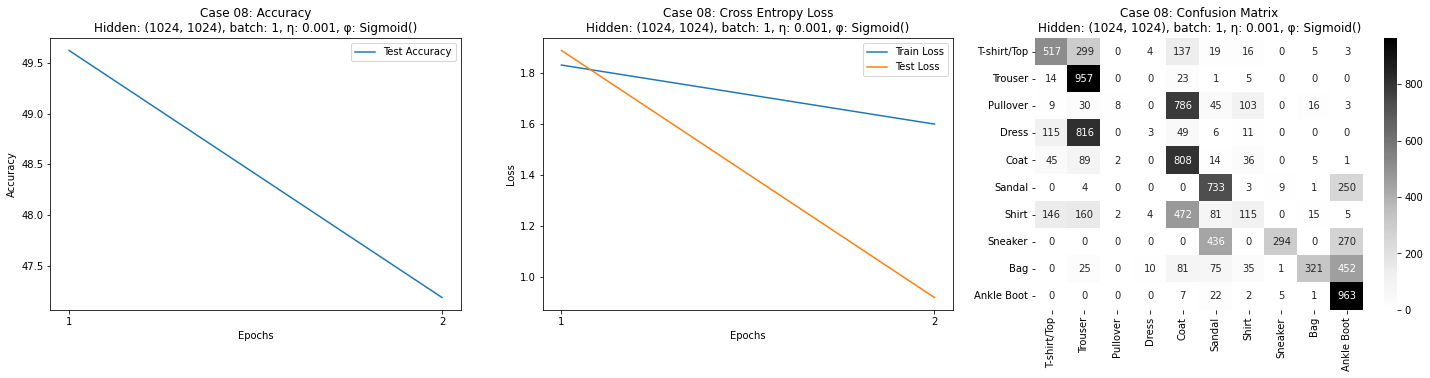

------------------------------------------------------------------------------------------
CASE: 09 Training Started: 01/16/2022 22:49:56
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.4320    Testing Loss: 1.1023    Testing Accuracy: 42.09%
Epoch 2/2  Training Loss: 1.4246    Testing Loss: 3.5271    Testing Accuracy: 31.65%
Completed Case 9/24: 0:00:37.834898 Elapsed



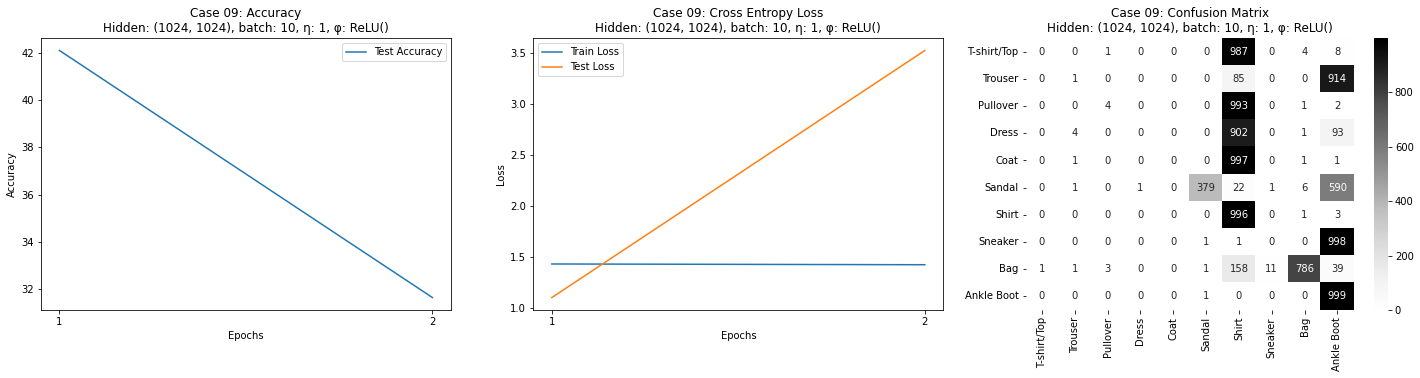

------------------------------------------------------------------------------------------
CASE: 10 Training Started: 01/16/2022 22:50:36
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.4886    Testing Loss: 0.3053    Testing Accuracy: 85.74%
Epoch 2/2  Training Loss: 0.1193    Testing Loss: 0.3195    Testing Accuracy: 86.58%
Completed Case 10/24: 0:00:37.736070 Elapsed



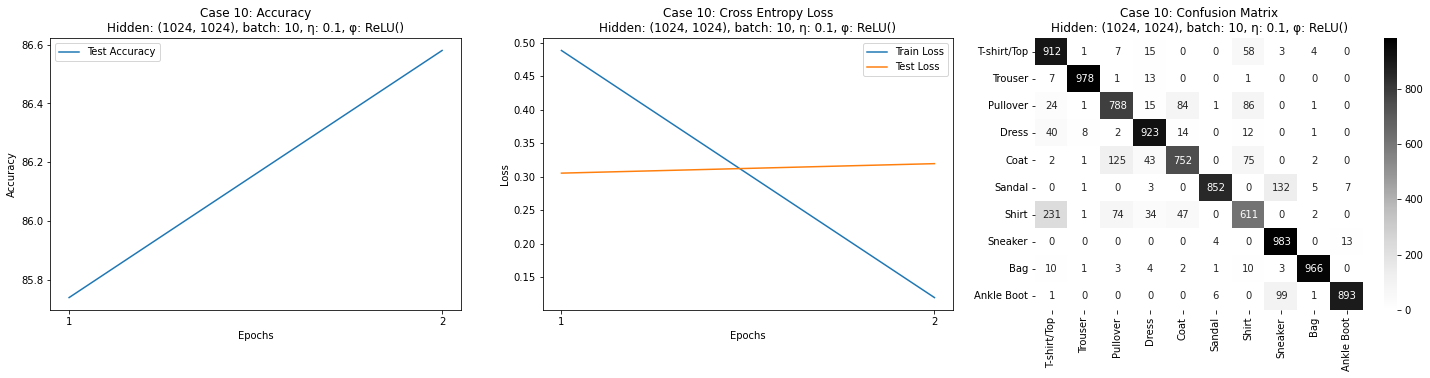

------------------------------------------------------------------------------------------
CASE: 11 Training Started: 01/16/2022 22:51:17
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.3836    Testing Loss: 0.3824    Testing Accuracy: 84.63%
Epoch 2/2  Training Loss: 0.0801    Testing Loss: 0.4011    Testing Accuracy: 86.32%
Completed Case 11/24: 0:00:38.143317 Elapsed



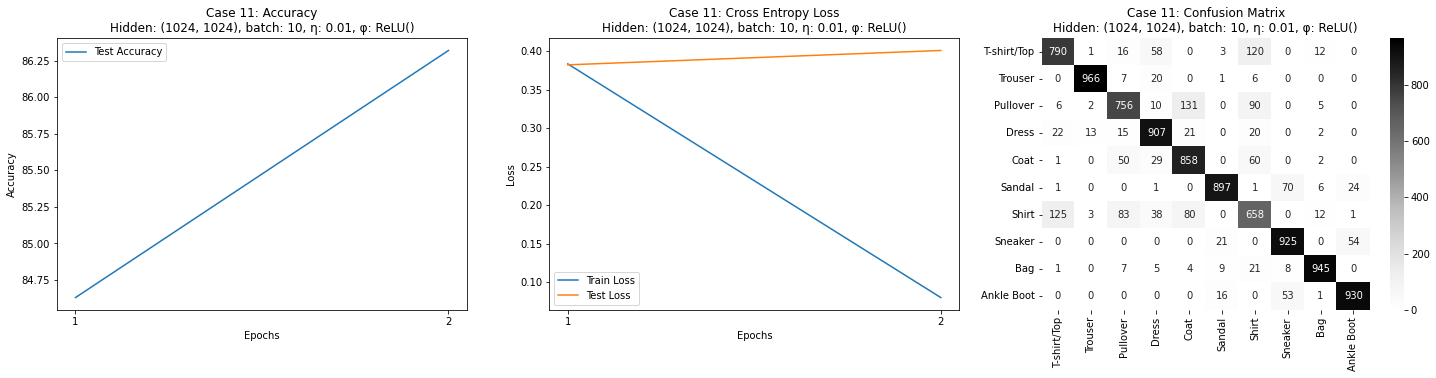

------------------------------------------------------------------------------------------
CASE: 12 Training Started: 01/16/2022 22:51:58
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.2990    Testing Loss: 1.0340    Testing Accuracy: 75.37%
Epoch 2/2  Training Loss: 0.5649    Testing Loss: 0.7664    Testing Accuracy: 78.99%
Completed Case 12/24: 0:00:38.242115 Elapsed



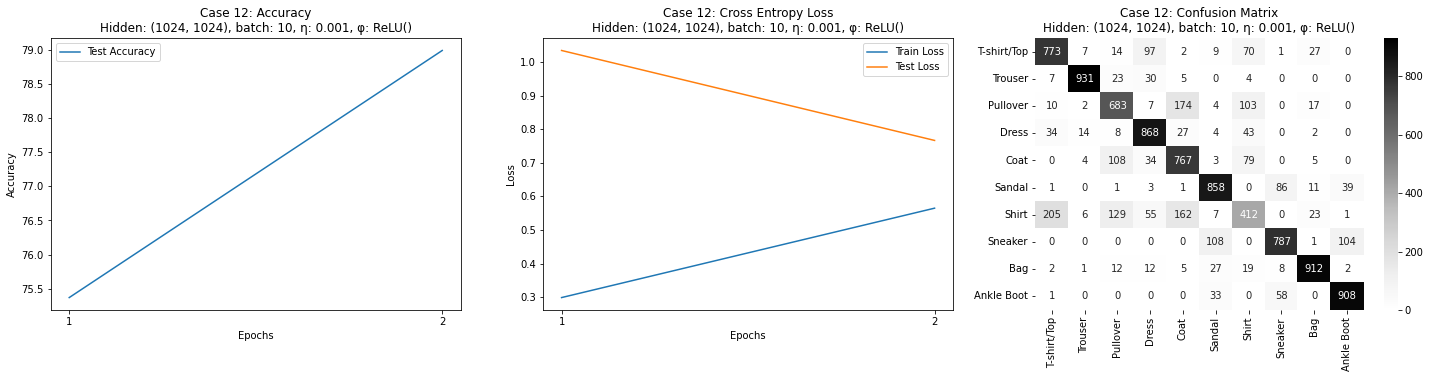

------------------------------------------------------------------------------------------
CASE: 13 Training Started: 01/16/2022 22:52:39
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.6298    Testing Loss: 0.6283    Testing Accuracy: 82.33%
Epoch 2/2  Training Loss: 0.3581    Testing Loss: 0.1784    Testing Accuracy: 85.33%
Completed Case 13/24: 0:00:38.020365 Elapsed



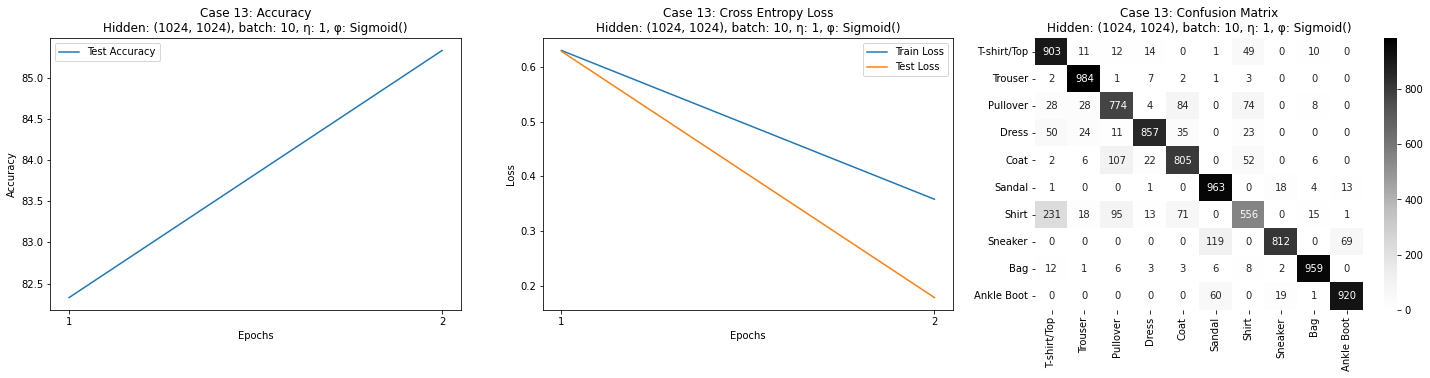

------------------------------------------------------------------------------------------
CASE: 14 Training Started: 01/16/2022 22:53:20
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.7925    Testing Loss: 0.5590    Testing Accuracy: 82.81%
Epoch 2/2  Training Loss: 0.5005    Testing Loss: 0.1980    Testing Accuracy: 84.36%
Completed Case 14/24: 0:00:38.080759 Elapsed



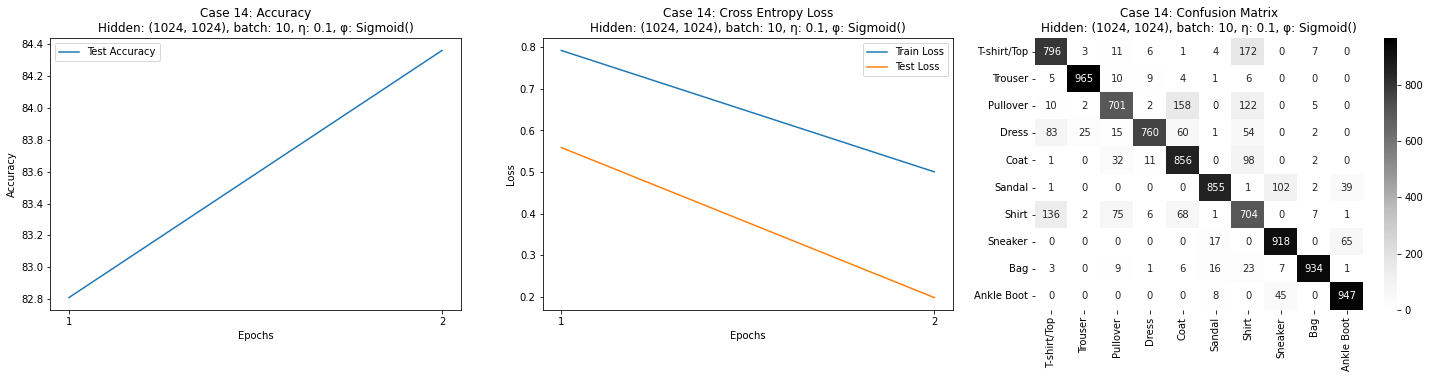

------------------------------------------------------------------------------------------
CASE: 15 Training Started: 01/16/2022 22:54:01
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.7550    Testing Loss: 0.7411    Testing Accuracy: 69.05%
Epoch 2/2  Training Loss: 0.6569    Testing Loss: 0.6409    Testing Accuracy: 76.0%
Completed Case 15/24: 0:00:38.200402 Elapsed



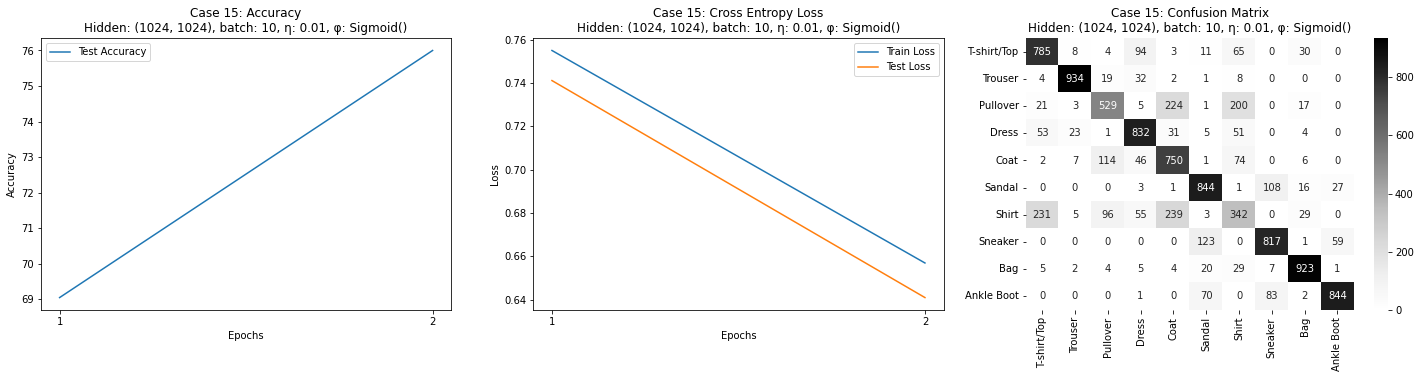

------------------------------------------------------------------------------------------
CASE: 16 Training Started: 01/16/2022 22:54:42
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    10
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2433    Testing Loss: 2.2626    Testing Accuracy: 34.03%
Epoch 2/2  Training Loss: 2.1130    Testing Loss: 2.0749    Testing Accuracy: 47.11%
Completed Case 16/24: 0:00:38.514536 Elapsed



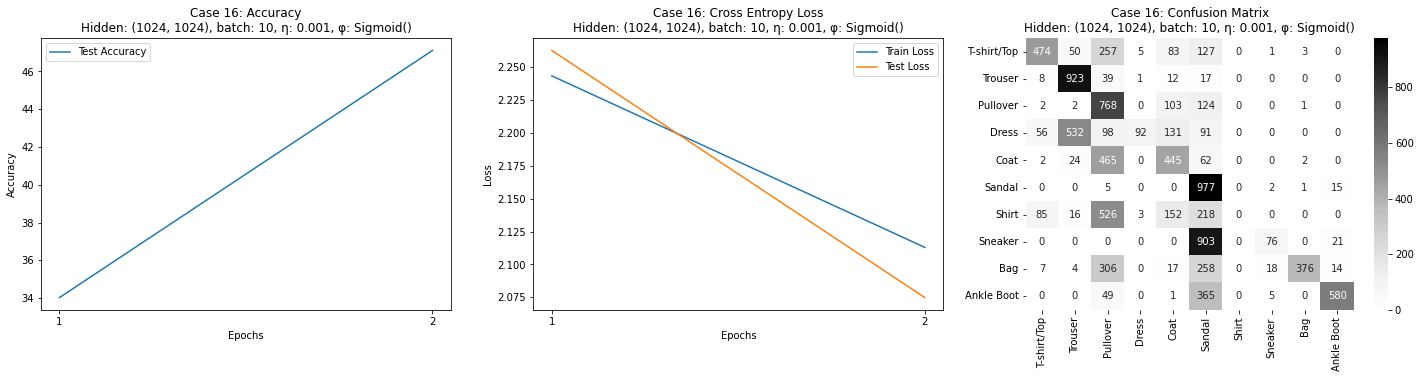

------------------------------------------------------------------------------------------
CASE: 17 Training Started: 01/16/2022 22:55:24
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.7681    Testing Loss: 0.6524    Testing Accuracy: 76.26%
Epoch 2/2  Training Loss: 0.4310    Testing Loss: 0.4763    Testing Accuracy: 81.56%
Completed Case 17/24: 0:00:18.770700 Elapsed



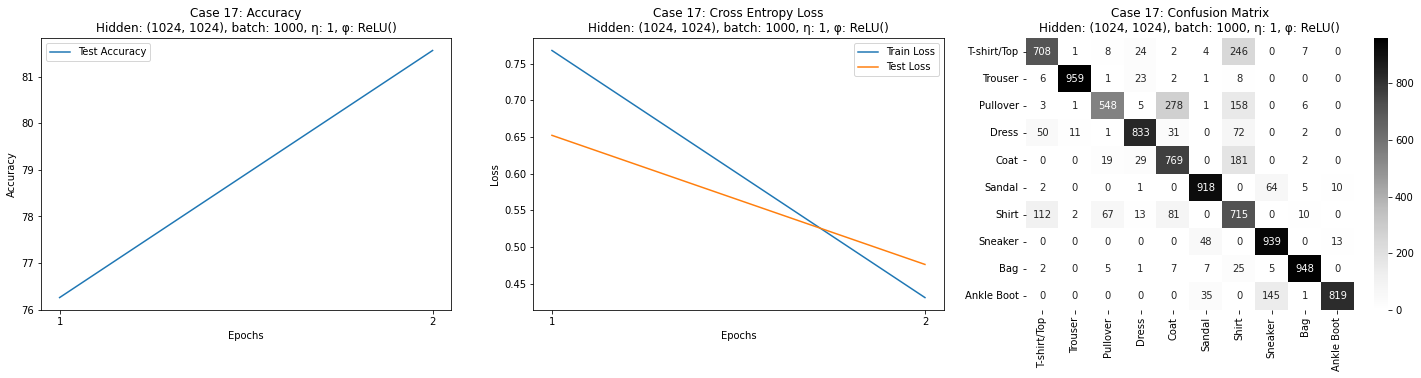

------------------------------------------------------------------------------------------
CASE: 18 Training Started: 01/16/2022 22:55:45
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 0.6292    Testing Loss: 0.6268    Testing Accuracy: 77.36%
Epoch 2/2  Training Loss: 0.5491    Testing Loss: 0.5649    Testing Accuracy: 80.94%
Completed Case 18/24: 0:00:18.788673 Elapsed



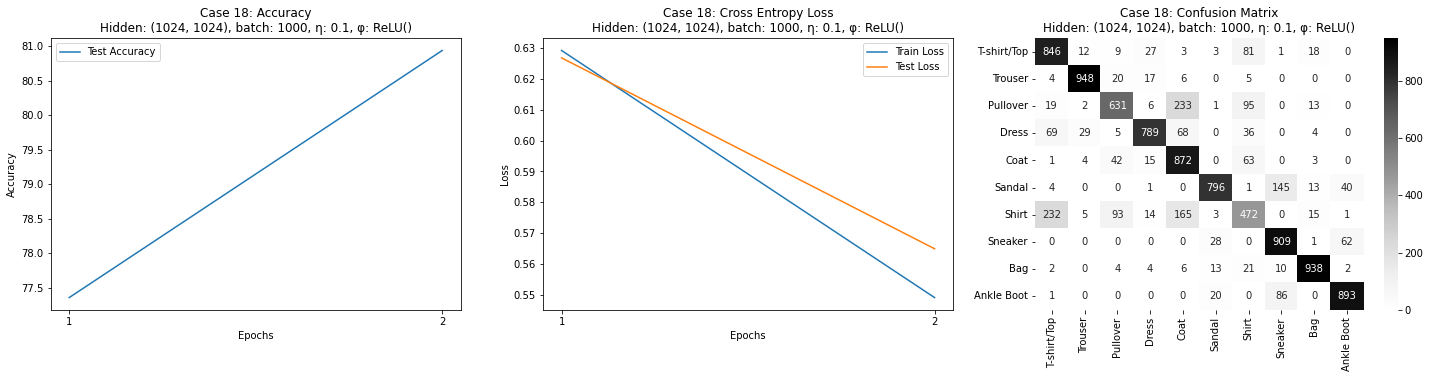

------------------------------------------------------------------------------------------
CASE: 19 Training Started: 01/16/2022 22:56:06
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.6656    Testing Loss: 1.6512    Testing Accuracy: 63.55%
Epoch 2/2  Training Loss: 1.1771    Testing Loss: 1.1694    Testing Accuracy: 68.74%
Completed Case 19/24: 0:00:18.932153 Elapsed



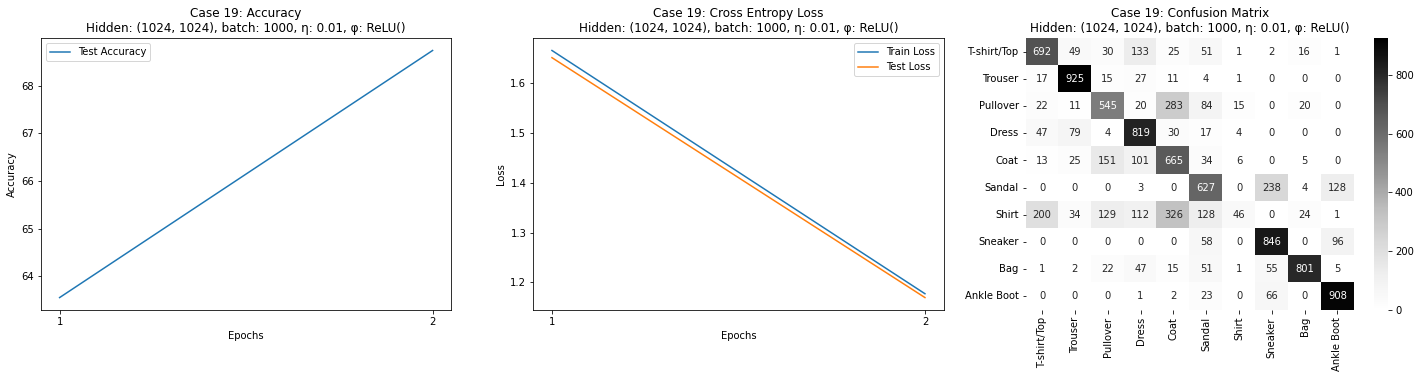

------------------------------------------------------------------------------------------
CASE: 20 Training Started: 01/16/2022 22:56:27
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    ReLU()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2466    Testing Loss: 2.2455    Testing Accuracy: 18.63%
Epoch 2/2  Training Loss: 2.1848    Testing Loss: 2.1896    Testing Accuracy: 38.94%
Completed Case 20/24: 0:00:19.002506 Elapsed



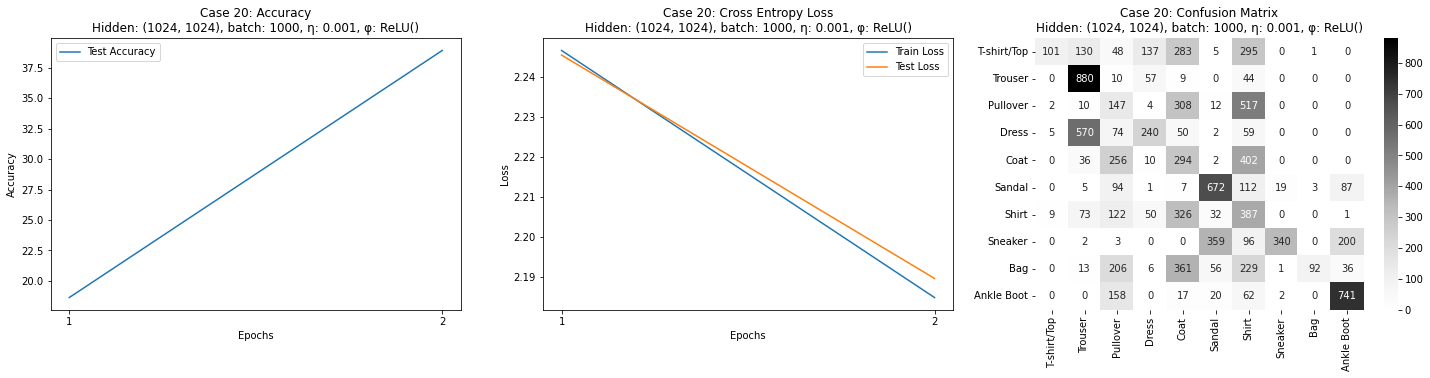

------------------------------------------------------------------------------------------
CASE: 21 Training Started: 01/16/2022 22:56:49
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 1.2788    Testing Loss: 1.2771    Testing Accuracy: 48.67%
Epoch 2/2  Training Loss: 0.8666    Testing Loss: 0.8871    Testing Accuracy: 63.62%
Completed Case 21/24: 0:00:19.050474 Elapsed



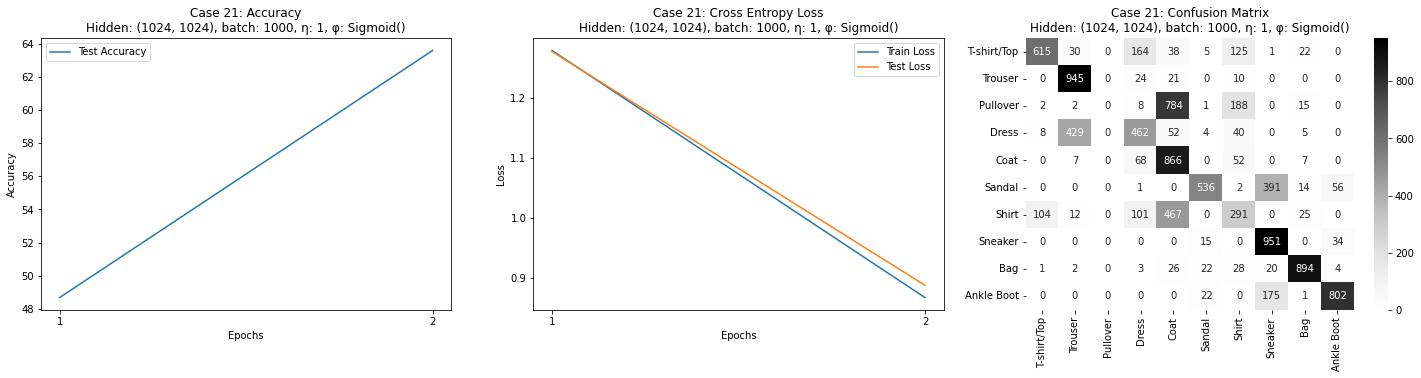

------------------------------------------------------------------------------------------
CASE: 22 Training Started: 01/16/2022 22:57:10
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.1
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2557    Testing Loss: 2.2134    Testing Accuracy: 21.03%
Epoch 2/2  Training Loss: 1.7444    Testing Loss: 1.7445    Testing Accuracy: 38.47%
Completed Case 22/24: 0:00:19.183010 Elapsed



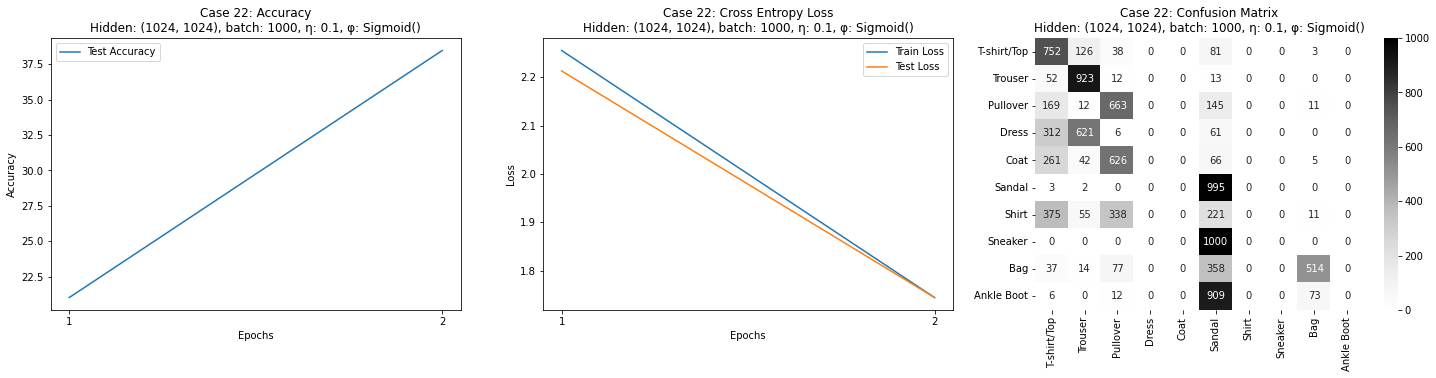

------------------------------------------------------------------------------------------
CASE: 23 Training Started: 01/16/2022 22:57:32
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.01
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.2911    Testing Loss: 2.2917    Testing Accuracy: 11.05%
Epoch 2/2  Training Loss: 2.2762    Testing Loss: 2.2779    Testing Accuracy: 18.33%
Completed Case 23/24: 0:00:19.122926 Elapsed



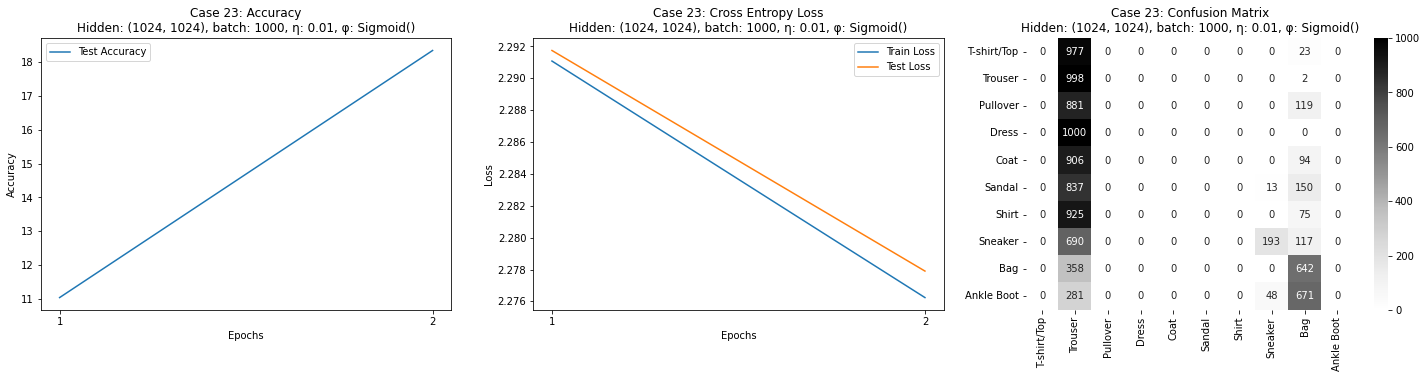

------------------------------------------------------------------------------------------
CASE: 24 Training Started: 01/16/2022 22:57:54
------------------------------------------------------------------------------------------
Hidden Layers: (1024, 1024)
Learning Rate: 0.001
Activation:    Sigmoid()
Batch Size:    1000
Epochs:        2
------------------------------------------------------------------------------------------
Epoch 1/2  Training Loss: 2.3016    Testing Loss: 2.3006    Testing Accuracy: 10.18%
Epoch 2/2  Training Loss: 2.2993    Testing Loss: 2.2989    Testing Accuracy: 11.01%
Completed Case 24/24: 0:00:18.864481 Elapsed



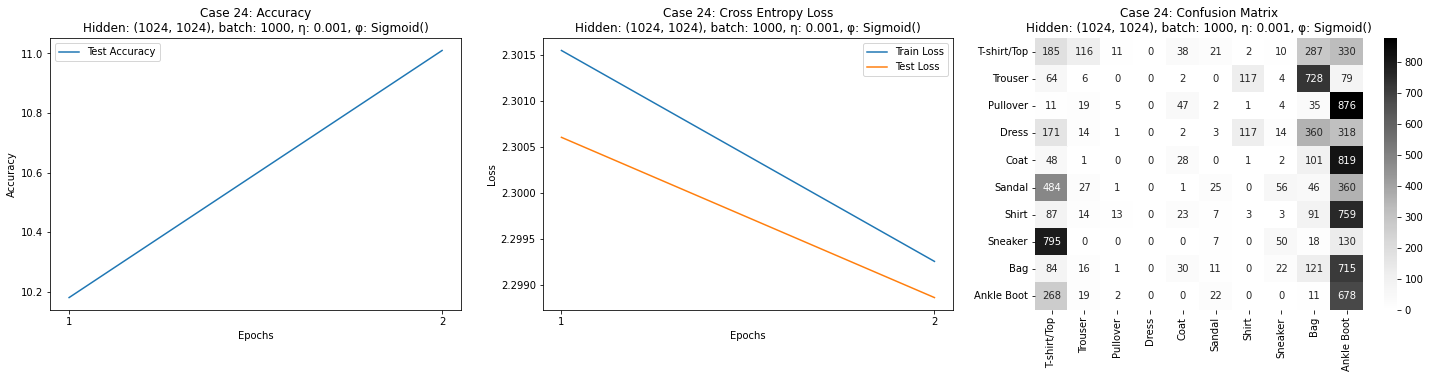

Total Elapsed Time: 0:36:29.417661




In [21]:
import time
import time as timer
import datetime
from datetime import timedelta

start = timer.time()
timestamp_pretty = time.strftime("%m/%d/%Y %H:%M:%S")
timestamp = time.strftime("%Y%m%d-%H%M%S")
print(f"3*4*2=24 Model Training - Started At: {timestamp_pretty}")

hidden_size = (1024, 1024)
momentum = 0
epochs = 2

# for faster testing
# params = {
#     'batch_size': [1],
#     'activation': [nn.ReLU()],
#     'learn_rate': [1, 0.1],
# }

params = {
    'batch_size': [1, 10, 1000],
    'activation': [nn.ReLU(), nn.Sigmoid()],
    'learn_rate': [1, 0.1, 0.01, 0.001],
}

i = 0
for batch_size in params['batch_size']:
    for activation in params['activation']:
        for learn_rate in params['learn_rate']:
            i += 1
            start_iteration = timer.time()
            start_train = datetime.datetime.now()
            start_train_str = start_train.strftime("%m/%d/%Y %H:%M:%S")
            print("------------------------------------------------------------------------------------------")
            print(f"CASE: {i:02d} Training Started: {start_train_str}")
            print("------------------------------------------------------------------------------------------")

            model = FashionModel(data_train=data_train, data_test=data_test, batch_size=batch_size)
            model.train(hidden_size=hidden_size, activation=activation,
                            learn_rate=learn_rate, momentum=momentum, epochs=epochs)

            elapsed = (time.time() - start_iteration)
            print(f"Completed Case {i}/24: {str(timedelta(seconds=elapsed))} Elapsed\n")

            display_model_visuals(model, f"Case {i:02d}");

elapsed = (time.time() - start)
print(f"Total Elapsed Time: {str(timedelta(seconds=elapsed))}\n\n")